In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import geopandas as gpd
import seaborn as sns
from matplotlib.colors import ListedColormap


In [2]:
all_batch = pd.read_csv('../combined_and_clean_data/combined_All_batch_participants.csv')

In [3]:
all_batch['Location'] = all_batch['Location'].replace('Taninthary', 'Tanintharyi')

In [4]:
myanmar_map = gpd.read_file('../geodata/myanmar_geo.geojson')
myanmar_map = myanmar_map.to_crs(epsg=3857)

In [5]:
location_count_df = all_batch['Location'].value_counts().reset_index()
location_count_df.columns = ['Location', 'Student_Count']
location_count_df

,Location,Student_Count
0,Yangon,23
1,Mandalay,7
2,Mon,5
3,Sagaing,4
4,Shan,3
5,Magway,3
6,Thailand (Mae Sot),2
7,Kachin,2
8,Kayin,2
9,Bago,1


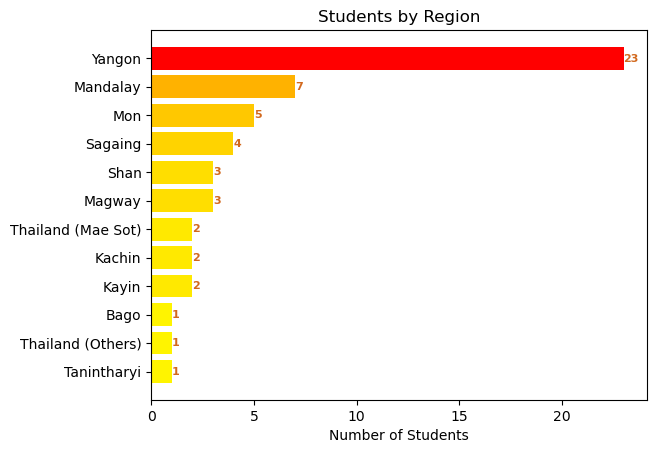

In [6]:
plt.barh(
    location_count_df['Location'], 
    location_count_df['Student_Count'], 
    height=0.8, 
    color= plt.cm.autumn_r(location_count_df['Student_Count']/location_count_df['Student_Count'].max())
    )
plt.gca().invert_yaxis()

for i, (count, location) in enumerate(zip(location_count_df['Student_Count'], location_count_df['Location'])):
    plt.text(count, i, f'{count}', va='center', ha='left', fontsize=8, color='chocolate', weight='bold')

plt.title('Students by Region')
plt.xlabel('Number of Students')
plt.show()

In [7]:
myanmar_map_student = myanmar_map.merge(location_count_df, how='left', left_on='ST', right_on='Location')

In [8]:
myanmar_map_student['Student_Count'] = myanmar_map_student['Student_Count'].fillna(0)

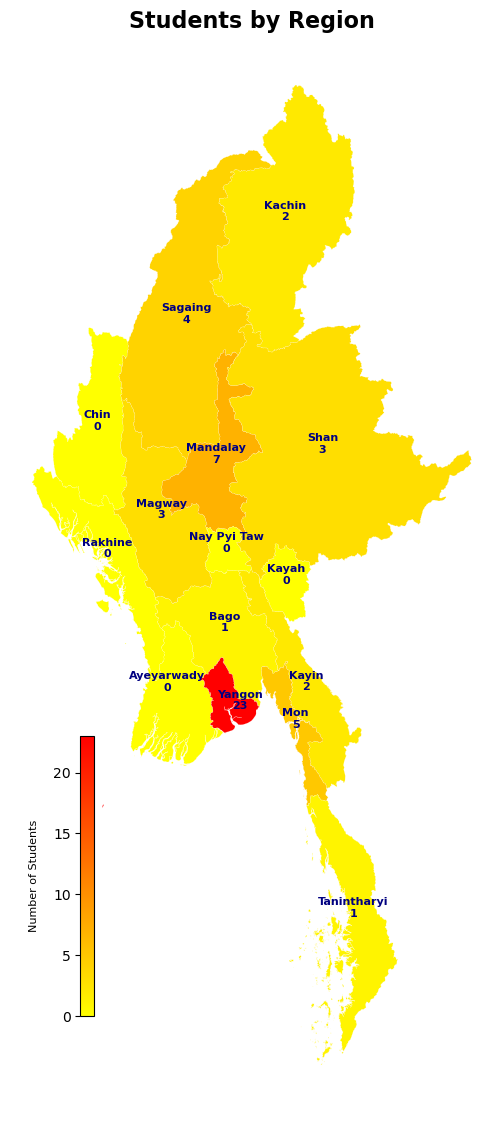

In [9]:
fig, ax = plt.subplots(1, 1, figsize=(14, 14))

map_plot = myanmar_map_student.plot(
    column='Student_Count', 
    ax=ax, 
    legend=True, 
    cmap='autumn_r', 
    edgecolor='white', 
    linewidth=0.1,
    )

cbar = map_plot.get_figure().axes[-1]
cbar.set_position([0.45, 0.18, 0.1, 0.2])
cbar.yaxis.set_label_position('left')
cbar.yaxis.tick_left()
cbar.set_ylabel('Number of Students', fontsize=8, labelpad=10)

for x, y, label, count in zip(
    myanmar_map_student.geometry.centroid.x,
    myanmar_map_student.geometry.centroid.y,
    myanmar_map_student['ST'], 
    myanmar_map_student['Student_Count']
):
    if label == 'Yangon':
        x, y = x + 30000, y - 20000 
    elif label == 'Ayeyarwady':
        x, y = x - 20000, y + 30000

    ax.annotate(
        f"{label}\n{int(count)}", 
        xy=(x, y), 
        fontsize=8, 
        ha='center', 
        color='navy', 
        weight='bold')

ax.set_title('Students by Region', fontsize=16, fontweight='bold')

plt.axis('off')
plt.show()

In [10]:
commitment_level = all_batch.pivot_table(index='Location', columns='Commitment', aggfunc='size', fill_value=0)

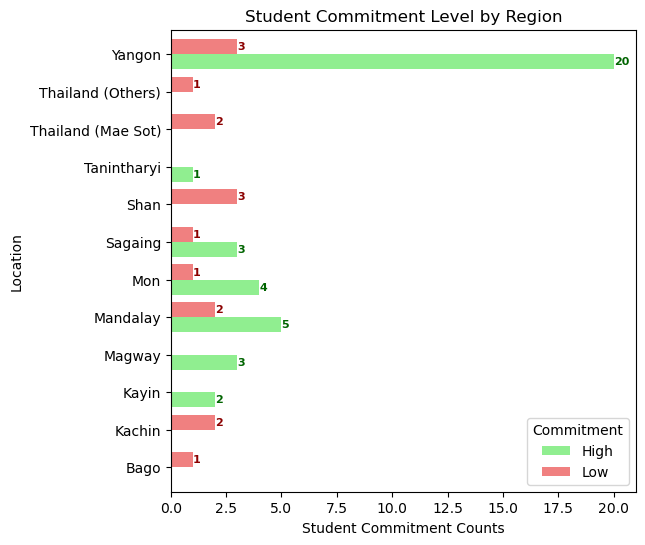

In [11]:
commitment_level.plot.barh(rot=0, color=['lightgreen', 'lightcoral'], width=0.8, figsize=(6,6))

for i, (location, row) in enumerate(commitment_level.iterrows()):
    # Label for High
    high_count = row['High']
    if high_count > 0:  # Only label if the count is greater than 0
        plt.text(high_count, i - 0.2, f'{high_count}', va='center', ha='left', fontsize=8, color='darkgreen', weight='bold')
    
    # Label for Low
    low_count = row['Low']
    if low_count > 0:  # Only label if the count is greater than 0
        plt.text(low_count, i + 0.2, f'{low_count}', va='center', ha='left', fontsize=8, color='darkred', weight='bold')

plt.xlabel('Student Commitment Counts')
plt.title('Student Commitment Level by Region')
plt.show()

In [12]:
commitment_level['Commitment_Level'] = commitment_level.apply(lambda row: 'High' if row['High'] > row['Low'] else 'Low', axis=1)

In [13]:
myanmar_map_commitment = myanmar_map.merge(commitment_level, how='left', left_on='ST', right_on='Location')

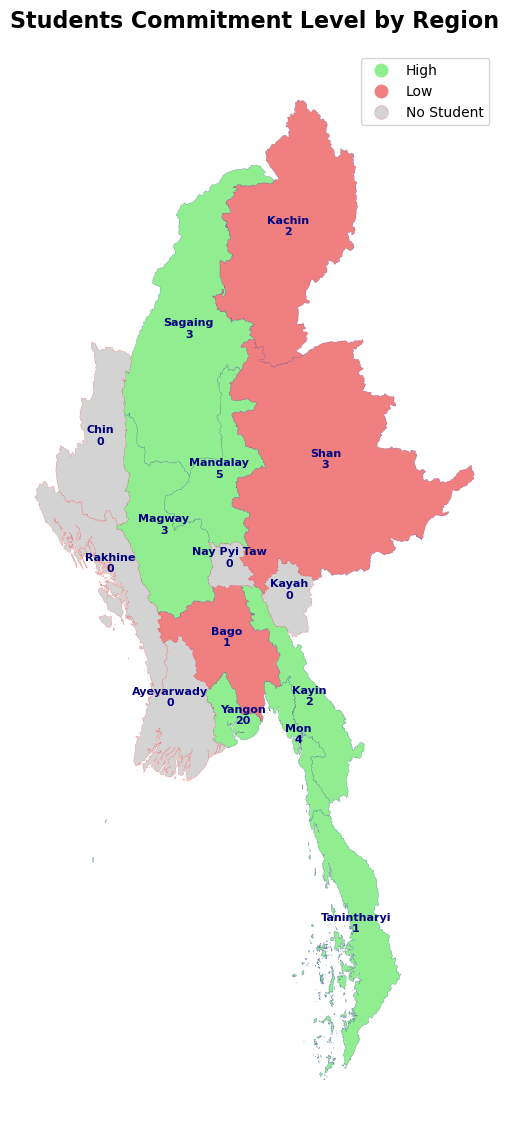

In [ ]:
color_mapping = {
    'High' : 'lightgreen',
    'Low' : 'lightcoral'
}

cmap = ListedColormap([color_mapping['High'], color_mapping['Low']])


fig, ax = plt.subplots(1, 1, figsize=(14, 14))

myanmar_map_commitment.plot(
    column='Commitment_Level',
    ax=ax,
    cmap=cmap, 
    legend=True,
    edgecolor='navy', 
    linewidth=0.1,
    missing_kwds={
        "color": "lightgrey",
        "edgecolor": "red",
        "label": "No Student",
    },
    )

for x, y, label, commitment in zip(
    myanmar_map_commitment.geometry.centroid.x,
    myanmar_map_commitment.geometry.centroid.y,
    myanmar_map_commitment['ST'], 
    myanmar_map_commitment['Commitment_Level']
):
    if label == 'Yangon':
        x, y = x + 30000, y - 20000 
    elif label == 'Ayeyarwady':
        x, y = x - 20000, y + 30000

    if commitment in ['High', 'Low']:
        count = myanmar_map_commitment.loc[myanmar_map_commitment['ST'] == label, commitment].values[0]
    else:
        count = 0

    ax.annotate(
        f"{label}\n{int(count)}", 
        xy=(x, y), 
        fontsize=8, 
        ha='center', 
        color='navy', 
        weight='bold')


ax.set_title('Students Commitment Level by Region', fontsize=16, fontweight='bold')

plt.axis('off')
plt.show()

In [16]:
high_commitment_region = commitment_level.loc[commitment_level['Commitment_Level'] == 'High'].sort_values('High', ascending=False)
high_commitment_region.drop(columns=['Low', 'Commitment_Level'], inplace=True)
high_commitment_region

Commitment,High
Location,
Yangon,20
Mandalay,5
Mon,4
Magway,3
Sagaing,3
Kayin,2
Tanintharyi,1


In [17]:
low_commitment_region = commitment_level.loc[commitment_level['Commitment_Level'] == 'Low'].sort_values('Low', ascending=False)
low_commitment_region.drop(columns=['High', 'Commitment_Level'], inplace=True)
low_commitment_region

Commitment,Low
Location,
Shan,3
Kachin,2
Thailand (Mae Sot),2
Bago,1
Thailand (Others),1


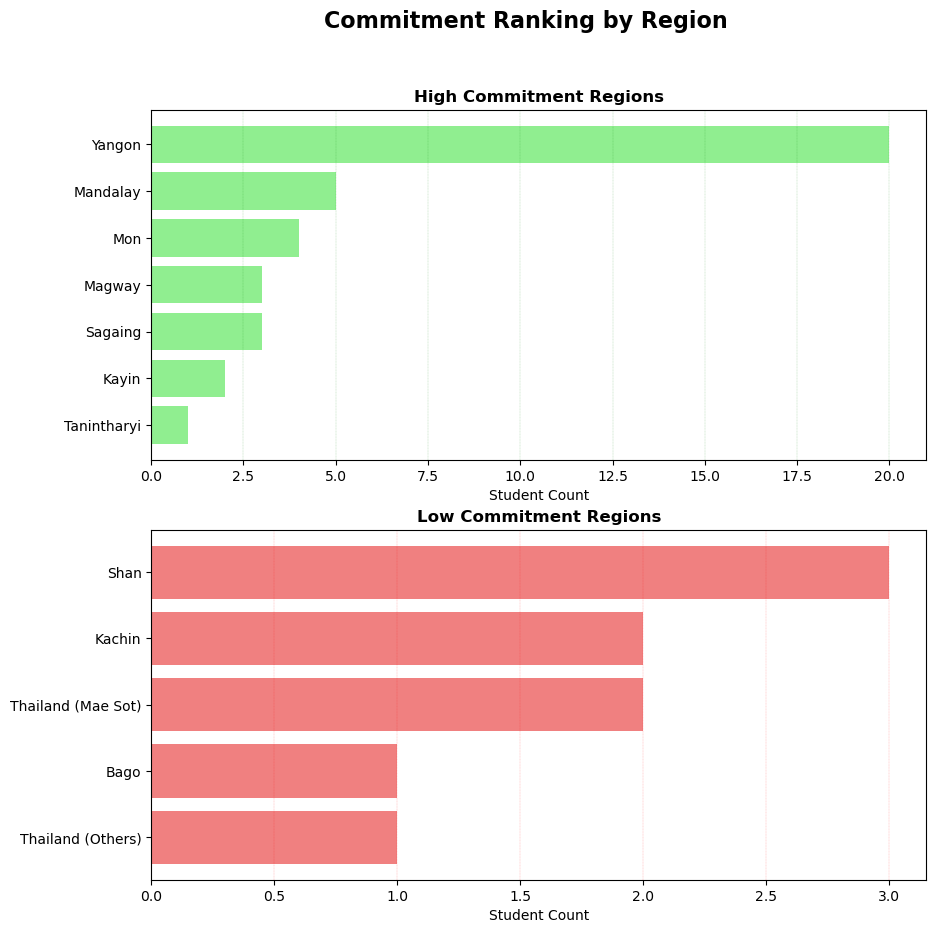

In [18]:
fig, ax = plt.subplots(2, 1, figsize=(10,10))

ax[0].barh(high_commitment_region.index, high_commitment_region['High'], color='lightgreen')
ax[0].set_title('High Commitment Regions', fontweight='bold')
ax[0].invert_yaxis()
ax[0].grid(axis='x', color='g', linestyle=':', linewidth=0.2)
ax[0].set_xlabel('Student Count')

ax[1].barh(low_commitment_region.index, low_commitment_region['Low'], color='lightcoral')
ax[1].set_title('Low Commitment Regions', fontweight='bold')
ax[1].invert_yaxis()
ax[1].grid(axis='x', color='r', linestyle=':', linewidth=0.2)
ax[1].set_xlabel('Student Count')

plt.suptitle('Commitment Ranking by Region', fontsize=16, fontweight='bold')
plt.show()

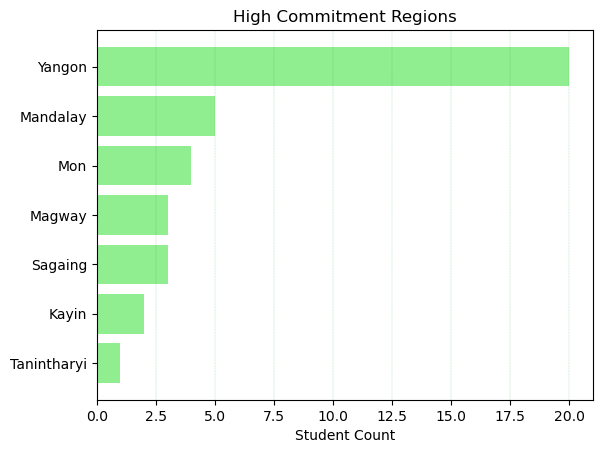

In [19]:
plt.barh(high_commitment_region.index, high_commitment_region['High'], color='lightgreen')
plt.title('High Commitment Regions')
plt.gca().invert_yaxis()
plt.grid(axis='x', color='g', linestyle=':', linewidth=0.2)
plt.xlabel('Student Count')
plt.show()

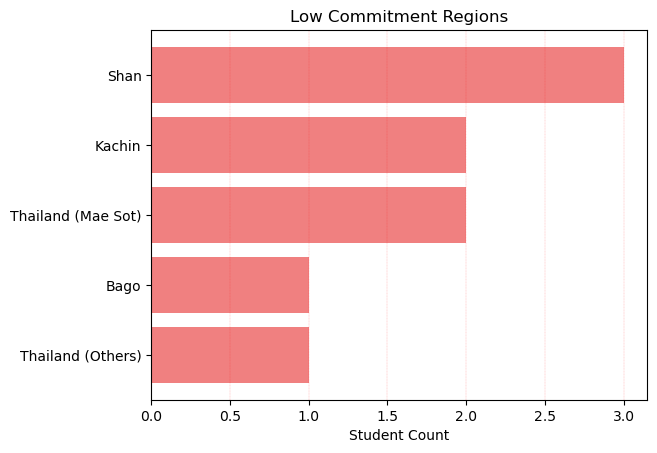

In [20]:
plt.barh(low_commitment_region.index, low_commitment_region['Low'], color='lightcoral')
plt.title('Low Commitment Regions')
plt.gca().invert_yaxis()
plt.grid(axis='x', color='r', linestyle=':', linewidth=0.2)
plt.xlabel('Student Count')
plt.show()

In [21]:
comit_lvl_region = all_batch.pivot_table(index=['Location', 'Commitment'], columns='Gender', aggfunc='size', fill_value=0)
comit_lvl_age = all_batch.pivot_table(index=['Age', 'Commitment'], columns='Gender', aggfunc='size', fill_value=0)
comit_lvl_edu = all_batch.pivot_table(index=['Highest Education', 'Commitment'], columns='Gender', aggfunc='size', fill_value=0)
comit_lvl_socio = all_batch.pivot_table(index=['Socio-economic background', 'Commitment'], columns='Gender', aggfunc='size', fill_value=0)

In [22]:
high_comit_region = comit_lvl_region.xs('High', level='Commitment')
low_comit_region = comit_lvl_region.xs('Low', level='Commitment')

high_comit_age = comit_lvl_age.xs('High', level='Commitment')
low_comit_age = comit_lvl_age.xs('Low', level='Commitment')

high_comit_edu = comit_lvl_edu.xs('High', level='Commitment')
low_comit_edu = comit_lvl_edu.xs('Low', level='Commitment')

high_comit_socio = comit_lvl_socio.xs('High', level='Commitment')
low_comit_socio = comit_lvl_socio.xs('Low', level='Commitment')

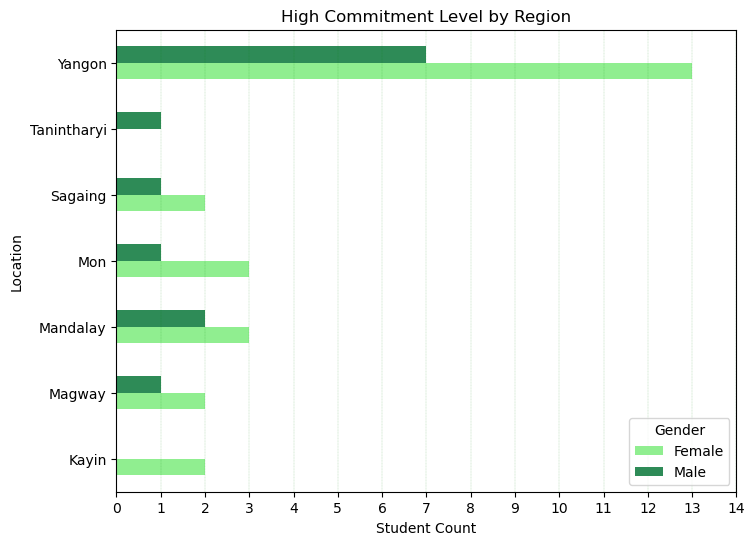

In [39]:
high_comit_region.plot(kind='barh', color=['lightgreen', 'seagreen'], figsize=(8,6))
plt.title('High Commitment Level by Region')
plt.grid(axis='x', color='g', linestyle=':', linewidth=0.2)
plt.xlabel('Student Count')
plt.xticks(range(0, 15, 1))
plt.show()

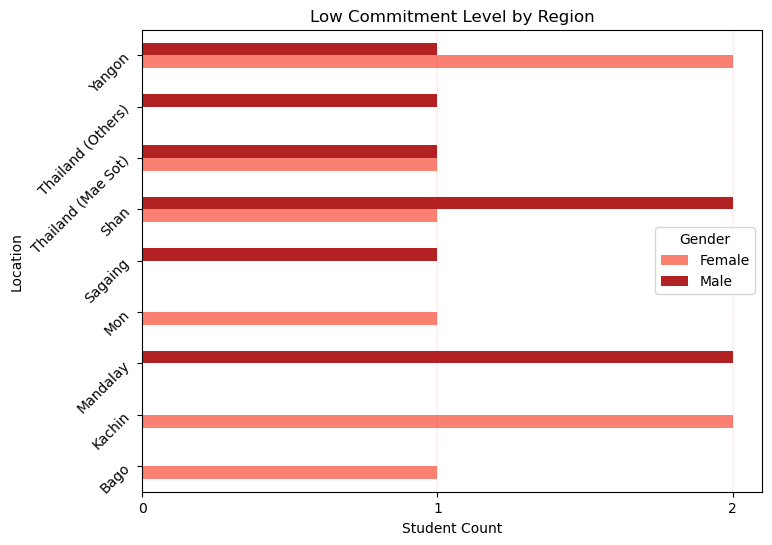

In [41]:
low_comit_region.plot(kind='barh', color=['salmon', 'firebrick'], figsize=(8,6))
plt.title('Low Commitment Level by Region')
plt.grid(axis='x', color='r', linestyle=':', linewidth=0.2)
plt.xlabel('Student Count')
plt.yticks(rotation=45)
plt.xticks(range(0, 3, 1))
plt.show()

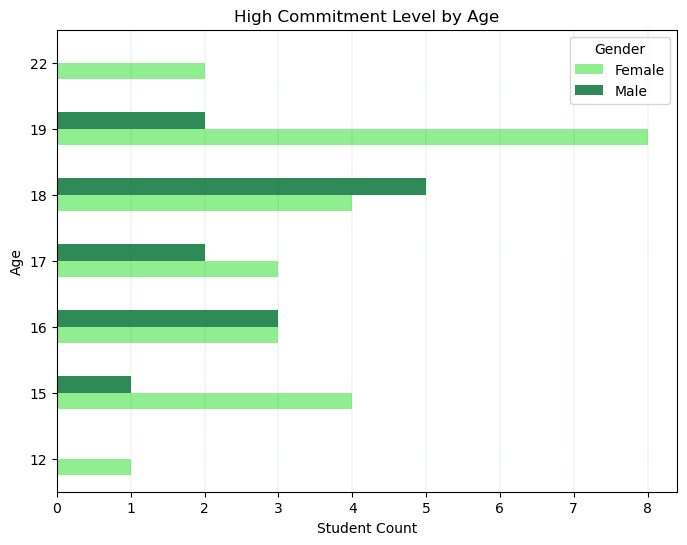

In [25]:
high_comit_age.plot(kind='barh', color=['lightgreen', 'seagreen'], figsize=(8,6))
plt.title('High Commitment Level by Age')
plt.grid(axis='x', color='g', linestyle=':', linewidth=0.2)
plt.xlabel('Student Count')
plt.show()

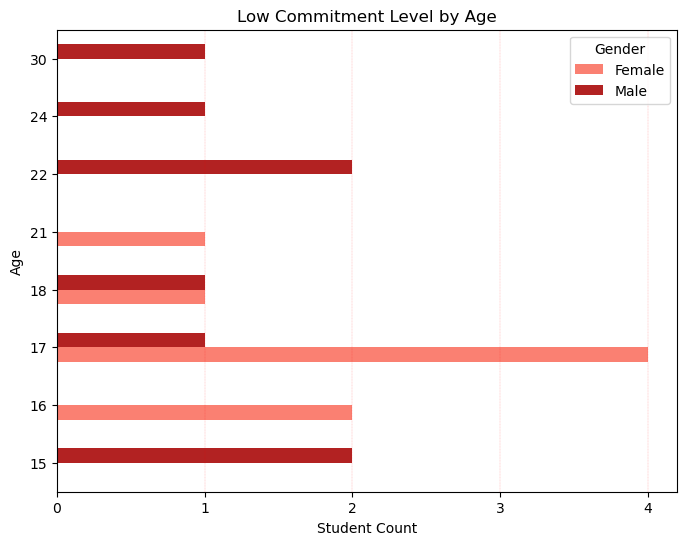

In [40]:
low_comit_age.plot(kind='barh', color=['salmon', 'firebrick'], figsize=(8,6))
plt.title('Low Commitment Level by Age')
plt.grid(axis='x', color='r', linestyle=':', linewidth=0.2)
plt.xlabel('Student Count')
plt.xticks(range(0, 5, 1))
plt.show()

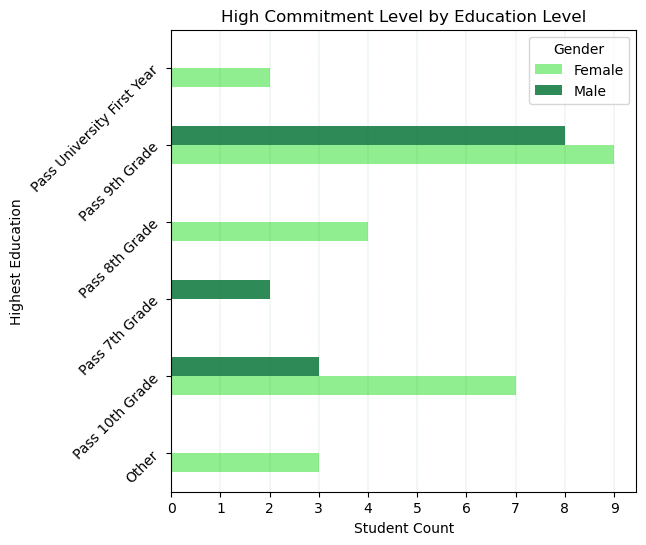

In [42]:
high_comit_edu.plot(kind='barh', color=['lightgreen', 'seagreen'], figsize=(6,6))
plt.title('High Commitment Level by Education Level')
plt.grid(axis='x', color='g', linestyle=':', linewidth=0.2)
plt.xlabel('Student Count')
plt.yticks(rotation=45)
plt.xticks(range(0, 10, 1))
plt.show()

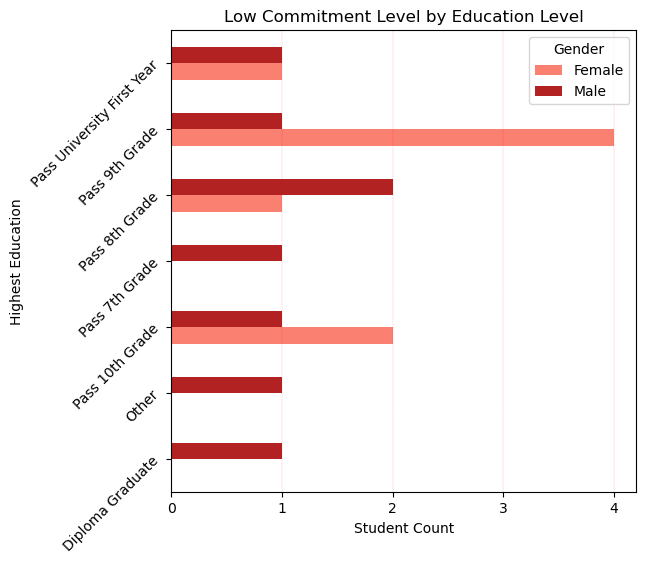

In [43]:
low_comit_edu.plot(kind='barh', color=['salmon', 'firebrick'], figsize=(6,6))
plt.title('Low Commitment Level by Education Level')
plt.grid(axis='x', color='r', linestyle=':', linewidth=0.2)
plt.xlabel('Student Count')
plt.yticks(rotation=45)
plt.xticks(range(0, 5, 1))
plt.show()

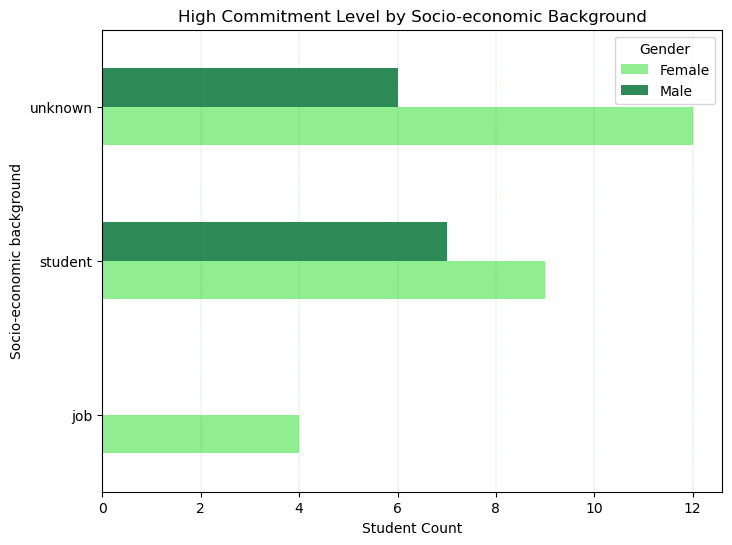

In [29]:
high_comit_socio.plot(kind='barh', color=['lightgreen', 'seagreen'], figsize=(8,6))
plt.title('High Commitment Level by Socio-economic Background')
plt.grid(axis='x', color='g', linestyle=':', linewidth=0.2)
plt.xlabel('Student Count')
plt.show()

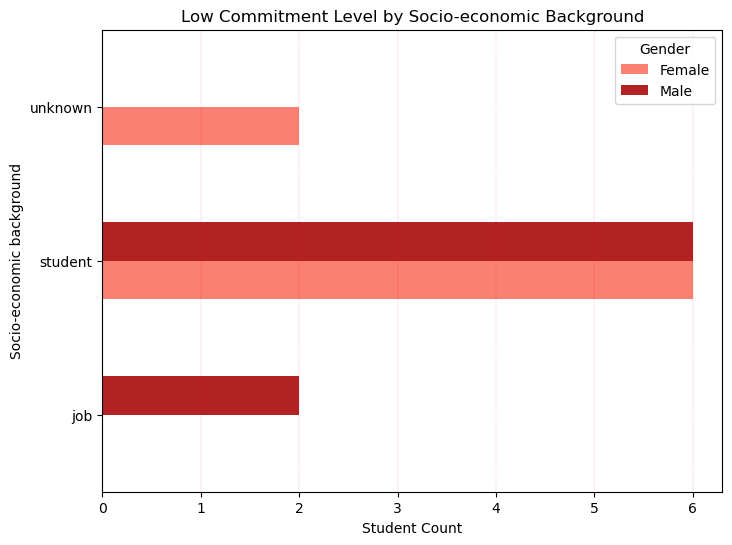

In [30]:
low_comit_socio.plot(kind='barh', color=['salmon', 'firebrick'], figsize=(8,6))
plt.title('Low Commitment Level by Socio-economic Background')
plt.grid(axis='x', color='r', linestyle=':', linewidth=0.2)
plt.xlabel('Student Count')
plt.show()